Logistic Regression Implementation


Test Accuracy = 0.954802
ROC AUC = 0.985429


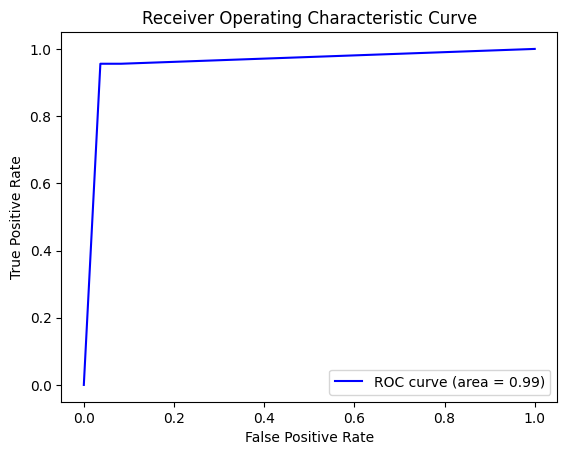

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

print("Logistic Regression Implementation\n\n")

# Initialize Spark session
spark = SparkSession.builder.appName("CancerDiagnosisLogisticRegression").getOrCreate()

# Load dataset
data = spark.read.csv('./project3_data.csv', header=True, inferSchema=True)

# Data preprocessing
labelIndexer = StringIndexer(inputCol="diagnosis", outputCol="indexedDiagnosis").fit(data)
featureCols = data.columns
featureCols.remove('diagnosis')
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
(trainData, testData) = data.randomSplit([0.7, 0.3])

# Define and train the Logistic Regression model
lr = LogisticRegression(labelCol="indexedDiagnosis", featuresCol="features")
pipeline = Pipeline(stages=[labelIndexer, assembler, lr])
lrModel = pipeline.fit(trainData)

# Make predictions
predictions = lrModel.transform(testData)

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="indexedDiagnosis", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % accuracy)

# Plot ROC curve (for binary classification)
if data.select("diagnosis").distinct().count() == 2:
    binary_evaluator = BinaryClassificationEvaluator(labelCol="indexedDiagnosis")
    roc_auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})
    print("ROC AUC = %g" % roc_auc)

    probs = predictions.select("probability").rdd.map(lambda x: x[0][1]).collect()
    labels = predictions.select("indexedDiagnosis").rdd.map(lambda x: x[0]).collect()

    fpr, tpr, _ = roc_curve(labels, probs)
    plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC curve not plotted as the classification problem is not binary.")
